In [7]:
import numpy as np

import pymisca.ext as pyext


import abc
class space__base(object):
    __metaclass__ = abc.ABCMeta
    @classmethod
    @abc.abstractmethod
    def get__neighbours(cls,x,targetAxis=None):
        assert 0
        return

class space__shifted(space__base):

#     pass
    shifters = [
        [(1,1,),(0,1)],
        [(1,-1),(0,1)],
        [(-1,1),(0,1)],
        [(-1,-1),(0,1)],
    ]
    
    @classmethod
    def get__neighbours(cls,x,targetAxis = (0,1),):
        '''
        return a list of neighbor
        '''
        lst = []
        for (shift,axis) in getattr(cls,"shifters"):
            axis = map(targetAxis.__getitem__, axis) 
            lst += [np.roll(x,shift,axis=axis)]
        return lst
    
    
# class dyn__lookup(object):
class dyn__lookup__bs(object):
    def __init__(self,table=None):
        if table is None:

            table = np.array([
                    [0,0,0,1,0,0,0,0,0,],
                    [0,0,1,1,0,0,0,0,0,],
                ])
        self.table = np.array(table)
#     @classmethod
    def forward(cls,x,xlst,targetAxis=(0,1),
                updater = None,
#                 updater=[slice(None,None)]
               ):
        
        y = np.stack(xlst,axis=0)
        SUM = np.sum(y,axis=0)
        x  =x.astype(int)

        y = cls.table[x,SUM]
        x[updater] = y[updater]

        return x
    
#     @classmethod
    def reverse(cls,xlst):
        return None
    
class space__moore(space__shifted):
    shifters = [
      [  (0,1),(0,1),],
      [  (1,1),(0,1),],
      [  (1,0),(0,1),],
      [  (1,-1),(0,1),],
      [  (0,-1),(0,1),],
      [  (-1,-1),(0,1),],
      [  (-1,0),(0,1),],
      [ (-1,1),(0,1),],
    ]
    
import itertools
def make__forwarder(space,dyn,targetAxis=(0,1),updater=None):
    def forwarder(x,targetAxis=targetAxis,updater=updater):
        nhs = space.get__neighbours(x,targetAxis)
        x = dyn.forward(x.copy(),nhs,targetAxis,updater)
        return x
    return forwarder

class Forwarder(object):
    def __init__(self,space,dyn,targetAxis=(0,1),updater=None):
        self.space= space
        self.dyn = dyn
        self.targetAxis = targetAxis
        self.updater = updater
    def run(self,x0,nIter,callback=None):
        x0 = np.array(x0)
        if np.ndim(x0)<3:
            x0 = x0[:,:,None]
            
        for i in range(nIter):
            if not i:
                x = x0
            else:
                nhs = self.space.get__neighbours(x,
                                                 self.targetAxis)
                x = self.dyn.forward(
                    x.copy(),nhs,
                    self.targetAxis,
                    self.updater)
                
            if callback is not None:
                callback(i,x)

        return x
    def run__hist(self,x0,nIter):
        hist = []
        callback = lambda i,x: hist.append(x)
        _ = self.run(x0,nIter,callback)
        return hist
    
        
        
    
def lookup__cast(forwarder, nodes):
    if not nodes:
        return nodes
    assert type(nodes[0]) in (tuple,list),(type(nodes[0]),)
#     for i in nIter:
    res = forwarder( np.array(nodes),targetAxis=(1,2))
    onodes = [x.tolist() for x in res]
#     onodes = [totuple(x) for x in res]
    return onodes
#     lookup = [nodes.index(x.tolist()) for x in res]
#     return lookup

def make__nodes(*shape):
    it = itertools.product(*[[0,1]]*np.product(shape))
    it = list(it)
    it = np.reshape(it,(-1,) + shape)
    lst = [x.tolist() for x in it]
    return lst

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a
    
def it__unique(seq): 
    uniq = []
    for ele in seq:
        if ele not in uniq:
            uniq.append(ele)
    return uniq
    
    

dyn__lookup__bs.table = np.array([
            [0,0,0,1,0,0,0,0,0,],
            [0,0,1,1,0,0,0,0,0,],
        ])

# dyn__lookup__bs.table = np.random.randint(0,2,size=
#                                          [2,9])


(20, 8, 7, 1)


(0, 250)

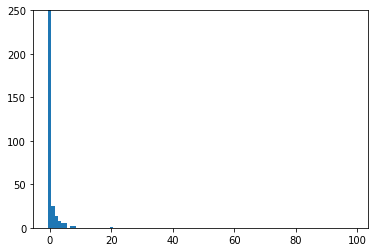

In [178]:
import scipy.ndimage
import collections


def scan__glider(y, metric, axis=None,debug=0):
    if axis is None:
        axis = range(len(metric))
    assert metric[0] >0 ,"time must >0"
    y = np.stack(y)
    metric = list(metric)
    mt = metric[:]
    mt[1:] = [0]*(len(mt)-1)
    ms = metric[:]
    ms[0]  = 0
    yr1 = np.roll(y, mt,  axis=axis)
    yr3 = np.roll(y, metric,axis = axis)
    z = (y==yr3) & (y!=yr1) & np.roll(y!=yr1,metric,axis)
    
    if debug:
        return dict(y=y,yr1=yr1,yr3=yr3,z=z)
    components,ct = scipy.ndimage.measurements.label(z[-mt[0]:][:,:,:,-1],
                                                     structure = np.ones((3,3,3))

#                                                      structure=np.stack([
#                                                          np.zeros((3,3)),
#                                                          np.ones((3,3)),
#                                                          np.zeros((3,3)),
#                                                                  ]),
                                                    )
    # [0]

    if not ct:
    #     ct = []
#         ct = []
        ct = {0:0}
    else:
        ct = components[components>0].ravel()
        ct = collections.Counter(ct)
    ct =  max(ct.values()) 
#     ct = np.median(ct.values())
    return ct
# d = scan__glider(hist,(1,-3,2),debug=0)
# d = scan__glider(hist,(4,-1,1),debug=0)

def rule__toBSString(ruleTable):
#     s = ""
    s = []
    for i,lst in enumerate(ruleTable):
#         s += "BS"[i]
        s += ["BS"[i]]
        for j,v in enumerate(lst):
            if v:
                s+=["%d"%j]
    return ''.join(s)

import pymisca.vis_util as pyvis
plt = pyvis.plt
%matplotlib inline

pt__glider = [
                [0,0,0,0,0,0,0],
                [0,1,1,1,0,0,0],
                [0,0,0,1,0,0,0],
                [0,0,1,0,0,0,0],
                [0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0],
                ]

def scan__hist(hist,):
    it = itertools.product(range(1,1+4),range(-4,4 + 1),range(-4,4 + 1))
    res =  [(scan__glider(hist,v),v) for v in it]
    return res
# pyvis.heatmap(d['z'][-1][:,:,0])
# pyvis.heatmap(d['z'][-2][:,:,0])
# pyvis.heatmap(d['z'][-3][:,:,0])

fowarder = Forwarder(space__moore,dyn__lookup__bs())
hist = fowarder.run__hist(pt__glider,20)
res = scan__hist(hist)


res = sorted(res)[::-1]
plt.hist([x[0] for x in res],bins=np.arange(0,100)-0.5
)

ax = plt.gca()
ax.set_ylim(0,250)

In [714]:
res[:5]

[(20, (4, -1, 1)),
 (8, (4, -1, 0)),
 (8, (3, -1, 0)),
 (7, (4, 0, 2)),
 (7, (4, -2, 0))]

In [675]:
scan__glider(hist,metric=(4,4,0),debug=1)['z'].shape

(50, 15, 15, 1)

In [255]:
# x,y= seq[i]
rule__toBSString([x,y])

rule__toBSString([x[::-1],y[::-1]])


'B01248S13578'

In [645]:
i = i-1

In [312]:
i =98

In [960]:
# i = 105

B01346
S02
B012347
S01346
300 B135678S014678
DONE


Text(0.5,1.05,'B135678S014678')

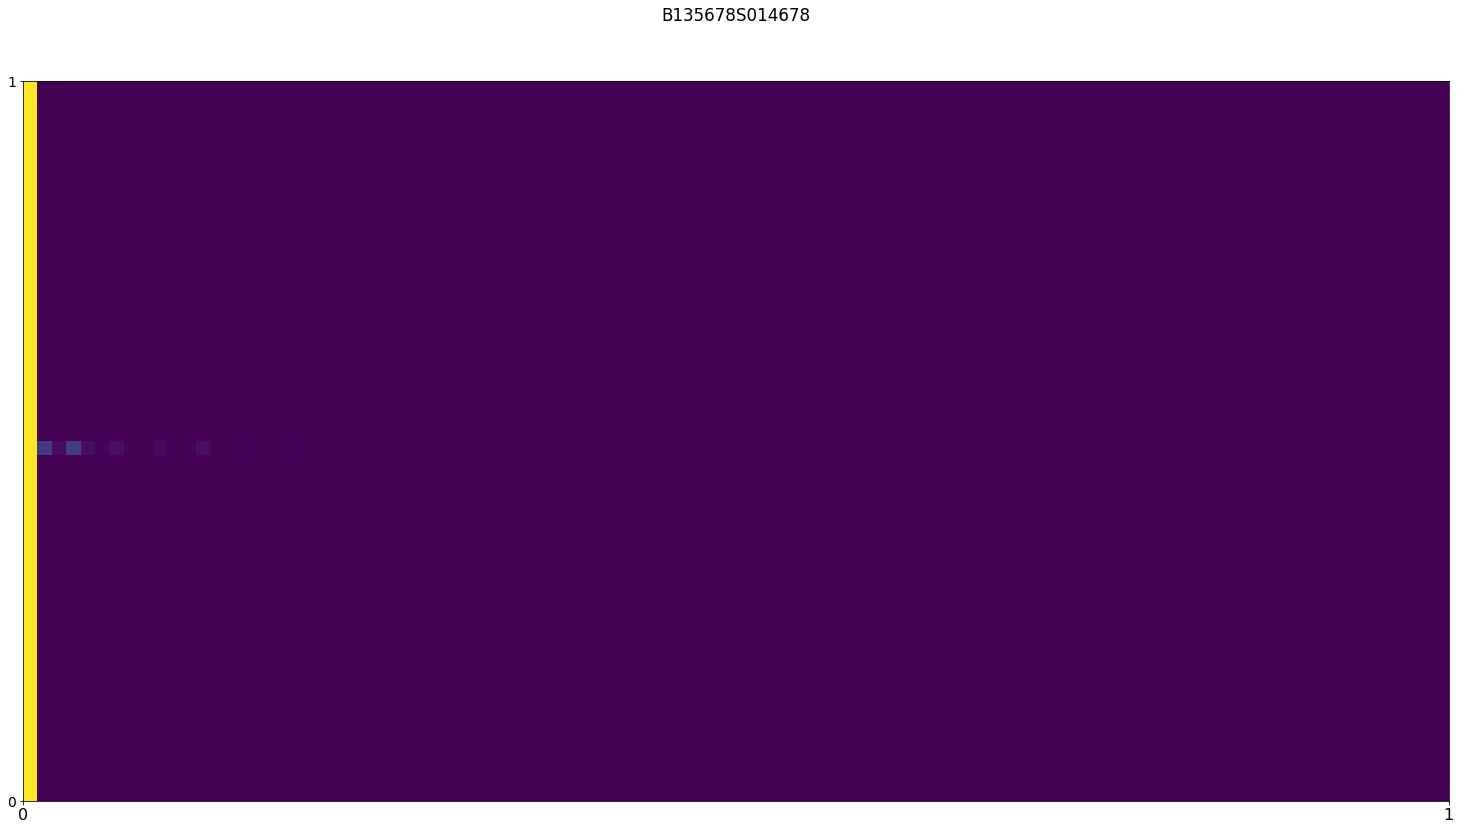

In [1179]:
fowarder = Forwarder(space__moore,dyn__lookup__bs())
fowarder = Forwarder(space__moore,dyn__lookup__bs(BSString__toRule("B01346/S02 ")))
# s = "B0125/S0125"
s = "B0123457/S346"
s = "B012347/S01346	"
fowarder = Forwarder(space__moore,dyn__lookup__bs(BSString__toRule(s)))

i = i+1
# i = 78
fowarder = Forwarder(space__moore,dyn__lookup__bs(seq[i]))

print i,rule__toBSString(fowarder.dyn.table)


bins = bins=np.arange(0,100)-0.5
out = []
for _ in range(50):
    hist = fowarder.run__hist(np.random.random(size=(15,15,1))>0.5,50)
    res = np.histogram([x[0] for x in scan__hist(hist)],bins=bins)[0]
    out += [res]

print "DONE"

name = rule__toBSString(fowarder.dyn.table)
pyvis.heatmap(np.array(out),vlim=[0,100])
fig = plt.gcf()
plt.title(name)

In [1181]:
np.save('gol/seq.npy',seq)

B0S8


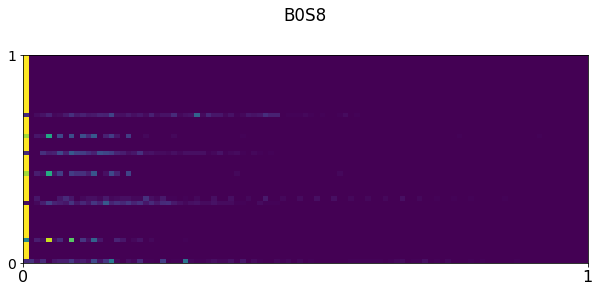

In [1177]:
fig
print name
fig.set_size_inches([8,3])
with pyext.getPathStack(['gol'],force=1):
    fig.savefig(name+'.png')
fig

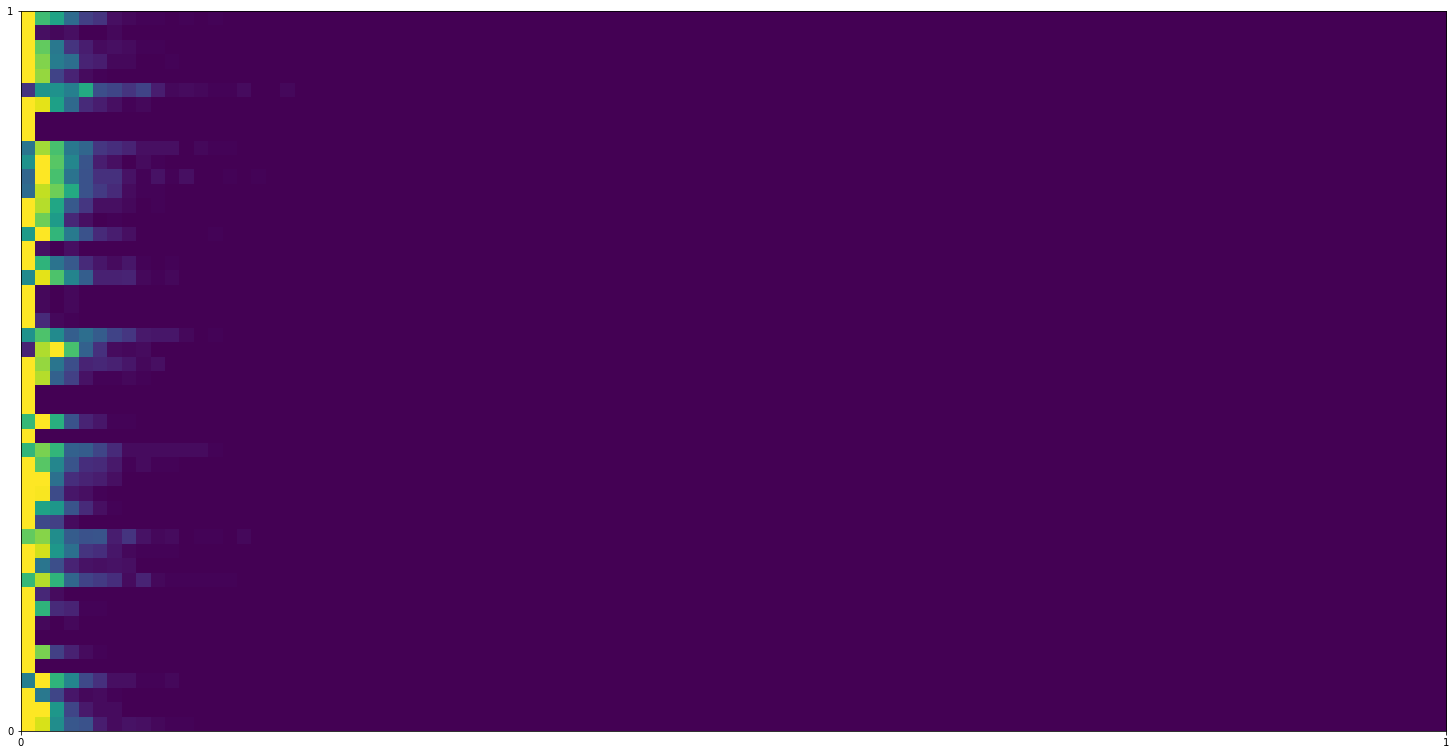

In [848]:
pyvis.heatmap(np.array(out),vlim=[0,100])

B01346
S02
193 B01346S02


[(182, (3, 1, 4)),
 (170, (3, 4, -4)),
 (154, (3, -3, 4)),
 (141, (3, 1, -4)),
 (131, (3, 2, -4))]

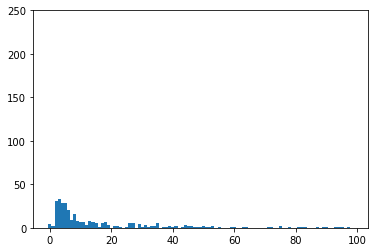

In [773]:
fowarder = Forwarder(space__moore,dyn__lookup__bs())
# i = i+1

fowarder = Forwarder(space__moore,dyn__lookup__bs(seq[i]))
fowarder = Forwarder(space__moore,dyn__lookup__bs(BSString__toRule("B01346/S02 ")))
print i,rule__toBSString(fowarder.dyn.table)

# fowarder = Forwarder(space__moore,seq[1])
hist = fowarder.run__hist(np.random.random(size=(15,15,1))>0.5,50)
res = scan__hist(hist)


res = sorted(res)[::-1]
plt.hist([x[0] for x in res],bins=np.arange(0,100)-0.5,
)
ax = plt.gca()
ax.set_ylim(0,250)

res[:5]

In [676]:
s = "B01238/S026"
import re
def BSString__toRule(s):
    res = [[0]*9 ,[0]*9 ]
    for sp in re.findall("([BS]\d*)",s):
    #     {"B":0,S}
#         print sp
        [ res["BS".index(sp[0])].__setitem__(int(x),1) for x in sp[1:]]
        
    return res

BSString__toRule("B01238/S026")

B01238
S026


[[1, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 1, 0, 0, 0, 1, 0, 0]]

In [ ]:
B012356S01236

In [ ]:
%%time
# seq = np.random.randint(0,2,size=(262144,2,9))
seq = make__nodes(2,9)
np.random.seed(0)
np.random.shuffle(seq)
# np.

In [217]:
print rule__toBSString(seq[65])

B16S12578


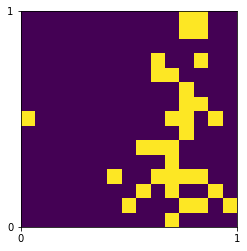

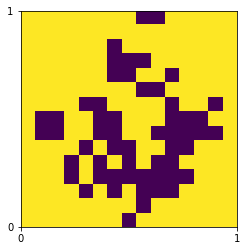

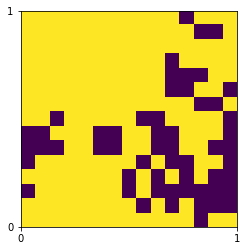

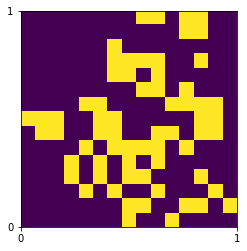

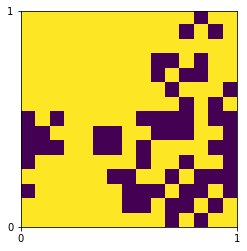

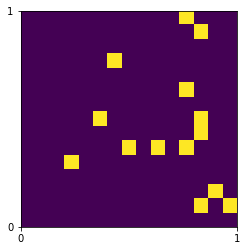

In [715]:
y=  hist
pyvis.heatmap(hist[-1][:,:,0])
d = scan__glider(hist,metric=res[0][1],debug=1)
pyvis.heatmap((d['yr3'] )[-1,:,:,0])
pyvis.heatmap((d['yr1'] )[-1,:,:,0])
pyvis.heatmap((d['y'] == d['yr3'])[-1,:,:,0])
pyvis.heatmap((d['y'] != d['yr1'])[-1,:,:,0])
pyvis.heatmap((d['z'])[-1,:,:,0])
# pyvis.heatmap(scan__glider(hist,metric=(4,4,0),debug=1)['z'][-1,:,:,0])
# pyvis.heatmap(np.roll(hist,(4,4,0),axis=(0,1,2))[-1][:,:,0])
# pyvis.heatmap(hist[-1][:,:,0])
# pyvis.heatmap((np.roll(hist[-1],(4,2,1),axis=(0,1,2))==hist[-1])[:,:,0])
# pyvis.heatmap(hist[-5][:,:,0])

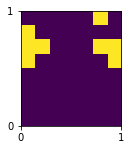

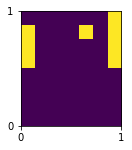

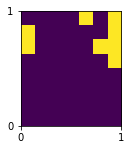

In [588]:
yr1 = np.roll(y,(4,0,0),axis=(0,1,2))
# yr2 = np.roll(y,(0,1,-1),axis=(0,1,2))
yr3 = np.roll(y,(4,-1,1),axis=(0,1,2))
z = (y==yr3) &~(yr1==y)
pyvis.heatmap(z[-1][:,:,0],vlim=[0,1])
pyvis.heatmap(z[-2][:,:,0],vlim=[0,1])
pyvis.heatmap(z[-3][:,:,0],vlim=[0,1])


components,ct = scipy.ndimage.measurements.label(z[-4:][:,:,:,-1],structure=np.ones((3,3,3)))
# [0]

if not ct:
#     ct = []
    ct = 0
else:
    ct = collections.Counter(components[components>0].ravel())
    ct =  max(ct.values())
# scipy.ndimage.find_objects(
#     scipy.ndimage.measurements.label(z[-4:][:,:,:,-1],structure=np.ones((3,3,3)))[0])
# pyvis.heatmap(z[-1][:,:,0])
# z[-1][:,:,0]

In [444]:
??scipy.ndimage.find_objects

In [445]:
??scipy.ndimage.measurements.label

In [437]:
?scipy.ndimage.measurements.label

In [284]:
def get_stats(table_bs,nodesMax = 8000, nForwardIter=5,onodesMax=400,):
    class _dyn(dyn__lookup__bs):
        table = np.array(table_bs)
    _f = make__forwarder(space__moore, _dyn)    
    def f(x,*a,**kw):
        for i in range(nForwardIter):
            x = _f(x,*a,**kw)
        return x
    nodes0= nodes = make__nodes(2,2)
    
    nIter = 4
    res = []
    callback = lambda i,x:res.append(len(x))
    for i in range(nIter):
        if not i:
            nodes = nodes0
        else:
#             nodes = [sum(_x,[]) for _x in itertools.product(x, x)]
#             nodes = [sum(_x,[]) for _x in itertools.product(x, nodes0)]
            nodes = [sum(zip(_x[0],_x[1]),()) + sum(zip(_x[2],_x[3]),()) for _x in itertools.product(x, nodes0,nodes0,nodes0)]
#             nodes = [sum(map(list,zip(_x[0],_x[1])),[]) + sum(map(list,zip(_x[2],_x[3])),[]) for _x in itertools.product(x, nodes0,nodes0,nodes0)]
    #     print len(nodes)
        if len(nodes) > nodesMax:
            print len(nodes)
            x = []
        else:
            onodes = lookup__cast(f,nodes)
            x = it__unique(onodes)
            if not i:
                nodes0 = x
            if len(x) > onodesMax:
                x=[]
        callback(i,x)
    return res

scanner = lambda tb: get_stats(tb,nodesMax=10000,nForwardIter=20)

tb = dyn__lookup__bs.table
res = [(tb,scanner(tb))]

print len(res)
map(lambda x:(rule__toBSString(x[0]),x[-1],), res)
# ,res

11250
1


[('B3S23', [5, 73, 90, 0])]

In [285]:
tb = seq[4597]
# tb = dyn__lookup__bs.table
res = [(tb,get_stats(tb,nodesMax=5000,nForwardIter=20))]

print len(res)
map(lambda x:(rule__toBSString(x[0]),x[-1],), res)
# ,res

10000
1


[('B1347S023468', [10, 0, 0, 0])]

In [11]:
%%time
# seq = np.random.randint(0,2,size=(262144,2,9))
seq = make__nodes(2,9)
np.random.seed(0)
np.random.shuffle(seq)
# np.

CPU times: user 1.44 s, sys: 88 ms, total: 1.52 s
Wall time: 1.51 s


In [114]:
out = {}

In [286]:
%%time
# for i in range()

# np.random.seed(0)
# seq = np.random.randint(0,2,size=(1000,2,9))
# start = 0
i0= 0

i0= 100
i0= 4500
lst = range(i0,i0+10)
def _worker(i,seq=seq):
    return (i,seq[i],scanner(seq[i]))

# def _worker(rule):
#     return (rule, get_stats(rule,nodesMax=2000))
%load_ext line_profiler
%lprun -f get_stats rules = map(_worker,lst)
# rules = pyext.mp_map(_worker,[i for i in lst], NCORE=1)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
15360
20736
193185
192512
CPU times: user 4.8 s, sys: 192 ms, total: 4.99 s
Wall time: 4.71 s


In [287]:
rules

[(4500,
  [[0, 0, 0, 1, 1, 0, 0, 1, 1], [1, 0, 0, 1, 1, 0, 1, 1, 1]],
  [2, 6, 6, 6]),
 (4501,
  [[0, 1, 1, 0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 1, 1, 0, 0, 1]],
  [4, 61, 136, 136]),
 (4502,
  [[1, 0, 1, 0, 1, 1, 1, 1, 1], [1, 1, 1, 0, 0, 0, 0, 1, 0]],
  [4, 98, 240, 0]),
 (4503,
  [[1, 0, 0, 1, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1, 1, 0, 1]],
  [3, 61, 201, 201]),
 (4504,
  [[0, 1, 1, 0, 1, 1, 1, 0, 1], [1, 0, 0, 1, 0, 1, 1, 0, 1]],
  [12, 0, 0, 0]),
 (4505,
  [[0, 1, 1, 1, 0, 1, 0, 1, 0], [0, 1, 0, 0, 1, 0, 1, 1, 1]],
  [8, 0, 0, 0]),
 (4506,
  [[1, 1, 1, 1, 0, 1, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 1]],
  [9, 265, 0, 0]),
 (4507,
  [[1, 1, 0, 0, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 1, 0, 0, 1]],
  [7, 0, 0, 0]),
 (4508,
  [[0, 1, 0, 1, 0, 1, 1, 1, 0], [0, 1, 0, 0, 1, 1, 0, 1, 1]],
  [8, 376, 0, 0]),
 (4509,
  [[1, 0, 1, 0, 1, 0, 1, 1, 1], [1, 0, 1, 1, 1, 0, 0, 1, 0]],
  [2, 8, 11, 11])]

In [289]:
# rules = pyext.mp_map(_worker,[seq[i] for i in lst], NCORE=1)
# rules = [(seq[i],get_stats(seq[i],nodesMax=2000)) for i in lst]
def sel(x):
    res = x[-1]
#     res = get_stats(rule, nodesMax=2000)
    yes = res[1] < 300 & res[1]
#     yes = (res[1]>10) & (res[0]<=10) & (res[3] > 0)
#     return yes
    return 1


res = filter(sel,rules)
print len(res)
out[i0] = res

res = filter(sel,rules)
tb = dyn__lookup__bs.table
pyext.printlines(
    map(lambda x:(x[0],rule__toBSString(x[1]),x[-1]), res)
)

10
(4500, 'B3478S034678', [2, 6, 6, 6])
(4501, 'B127S3458', [4, 61, 136, 136])
(4502, 'B0245678S0127', [4, 98, 240, 0])
(4503, 'B034S0568', [3, 61, 201, 201])
(4504, 'B124568S03568', [12, 0, 0, 0])
(4505, 'B12357S14678', [8, 0, 0, 0])
(4506, 'B012358S08', [9, 265, 0, 0])
(4507, 'B0145S01258', [7, 0, 0, 0])
(4508, 'B13567S14578', [8, 376, 0, 0])
(4509, 'B024678S02347', [2, 8, 11, 11])


In [226]:
tb = dyn__lookup__bs.table
# tb = seq[4597]
res = [(tb,get_stats(tb,nodesMax=2000,nForwardIter=20))]

print len(res)
map(lambda x:(rule__toBSString(x[0]),x[-1],), res)
# ,res

1


[('B1347S023468', [4, 25, 22, 228])]

In [187]:
res = sum([[[_v[-1],rule__toBSString(_v[0])] for _v in v] for k,v in out.items()],[])
sorted(res,key=lambda x:x[0][1])

TypeError: 'int' object is not iterable

In [194]:
get_stats(seq[4548],),get_stats(seq[4505],),

([16, 103, 802, 0], [19, 100, 776, 0])

In [120]:
# res = filter(sel,rules)
res = out[400]

# tb = dyn__lookup__bs.table
pyext.printlines(
    map(lambda x:(rule__toBSString(x[0]),x[-1]), res)
)
# # res = [(tb,get_stats(tb))]
# print len(res)
# zip(map(lambda x:rule__toBSString(x[0]), res),res)
# map(rule__toBSString,res)
    

('B013457S2346', [10, 28, 89, 0])


In [57]:
def rule__toBSString(ruleTable):
#     s = ""
    s = []
    for i,lst in enumerate(ruleTable):
#         s += "BS"[i]
        s += ["BS"[i]]
        for j,v in enumerate(lst):
            if v:
                s+=["%d"%j]
    return ''.join(s)
rule__toBSString(res[0])

'B012457S01346'

In [53]:
len(res)

1

In [17]:
nodes = [sum(_x,[]) for _x in itertools.product(x,x)]
%time onodes = lookup__cast(f,nodes)
%time x = it__unique(onodes)
print (len(x),)


nodes = [sum(_x,[]) for _x in itertools.product(x,x)]
%time onodes = lookup__cast(f,nodes)
%time x = it__unique(onodes)
print (len(x),)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 5.03 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.37 ms
(270,)
CPU times: user 1.06 s, sys: 136 ms, total: 1.2 s
Wall time: 1.2 s
CPU times: user 2min 5s, sys: 120 ms, total: 2min 5s
Wall time: 2min 5s
(20482,)


In [238]:
map(nodes.__getitem__,list(set(tbl))[:3])

[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
 [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1]],
 [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 1, 0]]]

In [41]:
?np.maximum